# Proposed Ensemble Models

Given the constraints and objectives, I will consider the following models for the ensemble:
	
    1.	Model 1: LSTM Network on Raw GPS Data
    
>•	Input Data: Sequences of raw GPS data (speed, progress, stride_frequency, etc.).

>•	Architecture: An LSTM network designed to capture temporal dependencies and patterns in the sequential data.

>•	Advantage: LSTMs are well-suited for time-series data and can learn complex temporal dynamics without the need for hand-engineered features like acceleration.

    2.	Model 2: 1D Convolutional Neural Network (1D-CNN)
	
>•	Input Data: The same raw GPS sequences as in Model 1.

>•	Architecture: A 1D-CNN that applies convolutional filters across the time dimension to detect local patterns.

>•	Advantage: CNNs can capture spatial hierarchies and are effective in recognizing patterns in sequences, potentially identifying features like sudden changes in speed or stride frequency.

    3.	Model 3: Transformer-based Model
	
>•	Input Data: Raw GPS sequences and possibly sectionals data.

>•	Architecture: A Transformer model that uses self-attention mechanisms to weigh the importance of different parts of the sequence.

>•	Advantage: Transformers can model long-range dependencies and focus on the most relevant parts of the sequence for prediction.

## Additional Models (Optional):

    4.	Model 4: Gated Recurrent Unit (GRU) Network

>•	Similar to LSTMs but with a simpler architecture, GRUs can be more efficient and may perform better on certain datasets.

>•	Model 5: Temporal Convolutional Network (TCN)

>•	TCNs are designed for sequential data and can capture long-term dependencies using causal convolutions and residual connections.


## Load Parquet Train, Test, and Validaion (VAL) Data:

/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/parquet/train_sequences.parquet

/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/parquet/test_sequences.parquet

/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/parquet/val_sequences.parquet

In [2]:
# Set Environment
import os
import pyspark.sql.functions as F
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, size, when, count
from src.data_preprocessing.data_prep1.data_utils import (
    save_parquet, gather_statistics, initialize_environment,
    load_config, initialize_logging, initialize_spark, drop_duplicates_with_tolerance,
    identify_and_impute_outliers, identify_and_remove_outliers, process_merged_results_sectionals,
    identify_missing_and_outliers
)

try:
    spark, jdbc_url, jdbc_properties, queries, parquet_dir, log_file = initialize_environment()
    # input("Press Enter to continue...")
except Exception as e:
    print(f"An error occurred during initialization: {e}")
    logging.error(f"An error occurred during initialization: {e}")

2024-12-27 11:16:27,213 - INFO - Environment setup initialized.


Spark session created successfully.


In [3]:
train_sequences_path = os.path.join(parquet_dir, "train_sequences.parquet")
val_sequences_path = os.path.join(parquet_dir, "val_sequences.parquet")
test_sequences_path = os.path.join(parquet_dir, "test_sequences.parquet")
train_sequences = spark.read.parquet(train_sequences_path)
val_sequences = spark.read.parquet(val_sequences_path)
test_sequences = spark.read.parquet(test_sequences_path)

In [56]:
train_sequences.printSchema()

root
 |-- race_date: date (nullable = true)
 |-- race_number: integer (nullable = true)
 |-- horse_id: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- gate_index: integer (nullable = true)
 |-- course_cd_ohe: vector (nullable = true)
 |-- equip_ohe: vector (nullable = true)
 |-- surface_ohe: vector (nullable = true)
 |-- trk_cond_ohe: vector (nullable = true)
 |-- weather_ohe: vector (nullable = true)
 |-- med_ohe: vector (nullable = true)
 |-- stk_clm_md_ohe: vector (nullable = true)
 |-- turf_mud_mark_ohe: vector (nullable = true)
 |-- race_type_ohe: vector (nullable = true)
 |-- scaled_features: vector (nullable = true)
 |-- aggregated_struct: struct (nullable = true)
 |    |-- avg_speed_agg: double (nullable = true)
 |    |-- max_speed_agg: double (nullable = true)
 |    |-- final_speed_agg: double (nullable = true)
 |    |-- avg_accel_agg: double (nullable = true)
 |    |-- fatigue_agg: double (nullable = true)
 |    |-- sectional_time_agg: double (nullable = 

In [4]:
# Convert to Pandas DataFrame
train_sequences_pd = train_sequences.toPandas()
val_sequences_pd = val_sequences.toPandas()
test_sequences_pd = test_sequences.toPandas()

# Extract features and labels
X_train = np.array([np.array(x) for x in train_sequences_pd['past_races_sequence']])
y_train = train_sequences_pd['label'].values
horse_ids_train = train_sequences_pd['horse_id'].values

X_val = np.array([np.array(x) for x in val_sequences_pd['past_races_sequence']])
y_val = val_sequences_pd['label'].values
horse_ids_val = val_sequences_pd['horse_id'].values

X_test = np.array([np.array(x) for x in test_sequences_pd['past_races_sequence']])
y_test = test_sequences_pd['label'].values
horse_ids_test = test_sequences_pd['horse_id'].values

# Ensure the data is in the correct shape for LSTM
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (18164, 10, 12), y_train shape: (18164,)
X_val shape: (7247, 10, 12), y_val shape: (7247,)
X_test shape: (6282, 10, 12), y_test shape: (6282,)


In [5]:
 # Label targets
print(np.unique(y_train))

[0 1 2 3 4]


In [14]:
label_dist = train_sequences.groupBy("label").count().orderBy("label")
label_dist.show()

+-----+-----+
|label|count|
+-----+-----+
|    0| 2480|
|    1| 2562|
|    2| 2546|
|    3| 2507|
|    4| 8069|
+-----+-----+



In [15]:
label_dist = val_sequences.groupBy("label").count().orderBy("label")
label_dist.show()

+-----+-----+
|label|count|
+-----+-----+
|    0|  958|
|    1| 1004|
|    2|  998|
|    3|  989|
|    4| 3298|
+-----+-----+



In [16]:
label_dist = test_sequences.groupBy("label").count().orderBy("label")
label_dist.show()

+-----+-----+
|label|count|
+-----+-----+
|    0|  835|
|    1|  847|
|    2|  856|
|    3|  835|
|    4| 2909|
+-----+-----+



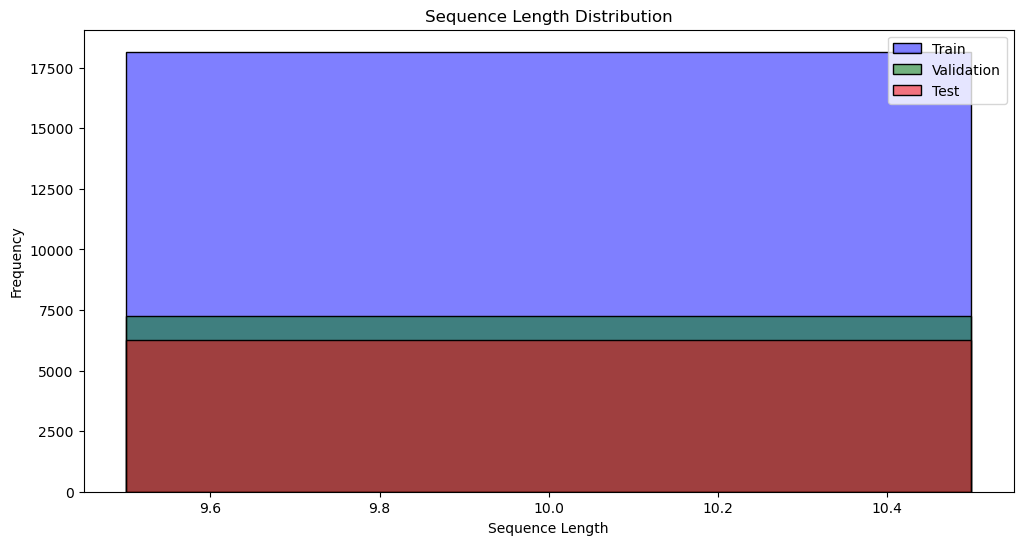

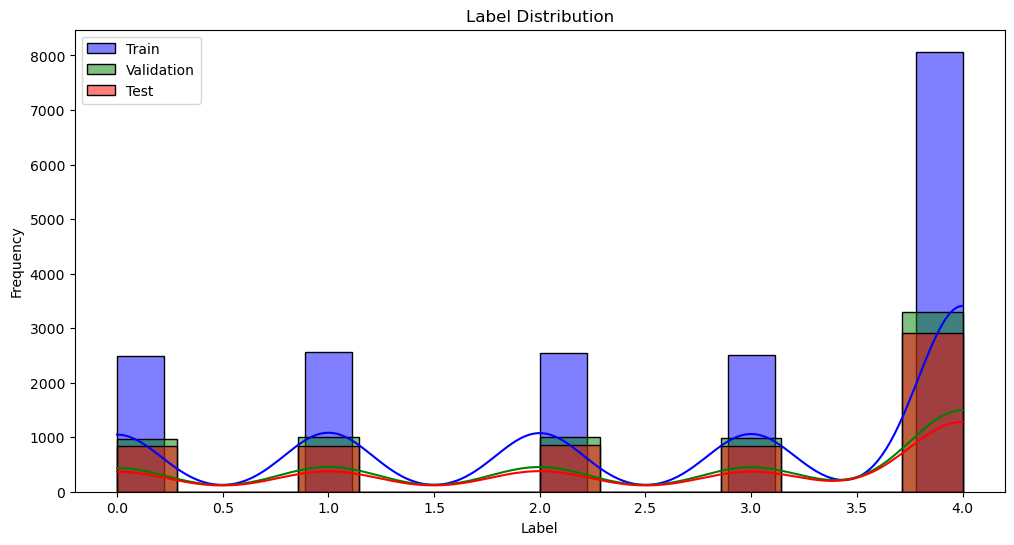

In [10]:

def show_distributions(train_sequences: DataFrame, val_sequences: DataFrame, test_sequences: DataFrame):
    """
    Show the distribution of sequence lengths and label distributions within the sequences.

    :param train_sequences: Spark DataFrame containing training sequences
    :param val_sequences: Spark DataFrame containing validation sequences
    :param test_sequences: Spark DataFrame containing test sequences
    """
    # Convert to Pandas DataFrame
    train_sequences_pd = train_sequences.toPandas()
    val_sequences_pd = val_sequences.toPandas()
    test_sequences_pd = test_sequences.toPandas()

    # Extract features and labels
    X_train = np.array([np.array(x) for x in train_sequences_pd['past_races_sequence']])
    y_train = train_sequences_pd['label'].values
    horse_ids_train = train_sequences_pd['horse_id'].values

    X_val = np.array([np.array(x) for x in val_sequences_pd['past_races_sequence']])
    y_val = val_sequences_pd['label'].values
    horse_ids_val = val_sequences_pd['horse_id'].values

    X_test = np.array([np.array(x) for x in test_sequences_pd['past_races_sequence']])
    y_test = test_sequences_pd['label'].values
    horse_ids_test = test_sequences_pd['horse_id'].values

    # Calculate sequence lengths
    train_seq_lengths = [len(seq) for seq in X_train]
    val_seq_lengths = [len(seq) for seq in X_val]
    test_seq_lengths = [len(seq) for seq in X_test]

    # Plot sequence length distributions
    plt.figure(figsize=(12, 6))
    sns.histplot(train_seq_lengths, kde=True, color='blue', label='Train')
    sns.histplot(val_seq_lengths, kde=True, color='green', label='Validation')
    sns.histplot(test_seq_lengths, kde=True, color='red', label='Test')
    plt.title('Sequence Length Distribution')
    plt.xlabel('Sequence Length')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    # Plot label distributions
    plt.figure(figsize=(12, 6))
    sns.histplot(y_train, kde=True, color='blue', label='Train')
    sns.histplot(y_val, kde=True, color='green', label='Validation')
    sns.histplot(y_test, kde=True, color='red', label='Test')
    plt.title('Label Distribution')
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Example usage
show_distributions(train_sequences, val_sequences, test_sequences)

In [20]:
import numpy as np
print("Label distribution in train:", np.bincount(y_train))
print("Label distribution in val:", np.bincount(y_val))
print("Label distribution in test:", np.bincount(y_test))


Label distribution in train: [2480 2562 2546 2507 8069]
Label distribution in val: [ 958 1004  998  989 3298]
Label distribution in test: [ 835  847  856  835 2909]


In [43]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, Dropout

# Define the input shapes
time_steps = X_train.shape[1]
features = X_train.shape[2]
num_horses = len(np.unique(horse_ids_train))

# Define the model
input_features = Input(shape=(time_steps, features), name='input_features')
input_horse_id = Input(shape=(1,), name='input_horse_id')

# Embedding layer for horse_id
embedding = Embedding(input_dim=num_horses, output_dim=32)(input_horse_id)
embedding = tf.keras.layers.Flatten()(embedding)

# LSTM layers
lstm_out = LSTM(128, return_sequences=True)(input_features)
lstm_out = Dropout(0.2)(lstm_out)
lstm_out = LSTM(64, return_sequences=False)(lstm_out)
lstm_out = Dropout(0.2)(lstm_out)

# Concatenate LSTM output with embedding
concat = Concatenate()([lstm_out, embedding])

# Dense layers
dense_out = Dense(64, activation='relu')(concat)
dense_out = Dropout(0.2)(dense_out)
output = Dense(5, activation='softmax')(dense_out)

# Define the model
model_lstm = Model(inputs=[input_features, input_horse_id], outputs=output)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model_lstm.compile(
    optimizer=optimizer,   # 'adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'] #,tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Display the model summary
model_lstm.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features      │ (None, 10, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 10, 128)   │     72,192 │ input_features[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 10, 128)   │          0 │ lstm_8[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_horse_id      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 64)        │     49,408 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 1, 32)     │    298,592 │ input_horse_id[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 64)        │          0 │ lstm_9[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 32)        │          0 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 96)        │          0 │ dropout_13[0][0], │
│ (Concatenate)       │                   │            │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      6,208 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64)        │          0 │ dense_8[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 5)         │        325 │ dropout_14[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 426,725 (1.63 MB)

 Trainable params: 426,725 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-4
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True
)

In [48]:
import numpy as np

# Train label counts from your distribution
train_counts = np.array([2480, 2562, 2546, 2507, 8069])
total = train_counts.sum()  # 18164
n_classes = len(train_counts)  # 5

class_weight = {}
for i, count_i in enumerate(train_counts):
    class_weight[i] = float(total) / (n_classes * count_i)

print(class_weight)
# Example output:
# {0: 1.463870..., 1: 1.416..., 2: 1.426..., 3: 1.446..., 4: 0.45...}

{0: 1.4648387096774194, 1: 1.4179547228727556, 2: 1.4268656716417911, 3: 1.4490626246509772, 4: 0.45021687941504523}


In [55]:
# Train the model

history = model_lstm.fit(
    [X_train, horse_ids_train],
    y_train,
    epochs=50,  
    batch_size=128,  # 64,
    validation_data=([X_val, horse_ids_val], y_val),
    callbacks=[
        lr_scheduler, 
        early_stopping,
        model_checkpoint
    ],
    class_weight=class_weight,
    verbose=1
)


SyntaxError: invalid syntax (2285623138.py, line 14)

In [54]:
preds = model_lstm.predict(X_val, input_features, input_horse_id)
print(np.argmax(preds, axis=-1)[:50])

TypeError: A symbolic KerasTensor cannot be used as a boolean.

In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate([X_val, horse_ids_val], y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

In [ ]:
# Save the trained model
#model.save('/path/to/save/model.h5')